In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
def show(images, num_images, size, nrows):
  grid = make_grid(images.detach().cpu().view(-1, *size)[:num_images], nrow=nrows)
  plt.imshow(grid.permute(1, 2, 0).squeeze())
  plt.show()

## **Generator**

In [3]:
def generator_block(input, output):
  x = nn.Sequential(
      nn.Linear(input, output),
      nn.BatchNorm1d(output),
      nn.ReLU(inplace=True)
  )
  return x

In [4]:
class Generator(nn.Module):
  def __init__(self, noise_dim, image_dim, hidden_dim):
    super(Generator, self).__init__()
    self.generator = nn.Sequential(
        generator_block(noise_dim, hidden_dim),
        generator_block(hidden_dim, hidden_dim * 2),
        generator_block(hidden_dim * 2, hidden_dim * 4),
        generator_block(hidden_dim * 4, hidden_dim * 8),
        nn.Linear(hidden_dim * 8, image_dim),
        nn.Sigmoid()
    )

  def forward(self, noise):
    return self.generator(noise)

In [5]:
def get_noise_vectors(n_samples, noise_dim, device):
  return torch.randn(n_samples, noise_dim, device=device)

## **Discriminator**

In [6]:
def discriminator_block(input, output):
  x = nn.Sequential(
      nn.Linear(input, output),
      nn.LeakyReLU(0.2, inplace=True)
  )
  return x

In [7]:
class Discriminator(nn.Module):
  def __init__(self, image_dim, hidden_dim):
    super(Discriminator, self).__init__()
    self.discr = nn.Sequential(
        discriminator_block(image_dim, hidden_dim * 4),
        discriminator_block(hidden_dim * 4, hidden_dim * 2),
        discriminator_block(hidden_dim * 2, hidden_dim),
        nn.Linear(hidden_dim, 1)
    )

  def forward(self, image):
    return self.discr(image)

In [8]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
noise_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'

image_height = 28
image_width = 28
image_channels = 1
image_flat_dim = image_height * image_width * image_channels

## **Loading Images**

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [10]:
trainset = datasets.MNIST('MNIST', train=True,
                          transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



## **Initializing Generator and Discriminator**

In [11]:
gen = Generator(noise_dim=noise_dim, image_dim=image_flat_dim, hidden_dim=128).to(device)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr)
discr = Discriminator(image_dim=image_flat_dim, hidden_dim=128).to(device)
discr_optimizer = torch.optim.Adam(discr.parameters(), lr=lr)

## **Calculating Loss**


In [12]:
def disc_loss(gen, disc, criterion, real, num_images, noise_dim, device):
  fake_noise = get_noise_vectors(num_images, noise_dim, device=device)
  fake = gen(fake_noise)
  fake_pred = disc(fake.detach())
  disc_fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
  real_pred = disc(real)
  disc_real_loss = criterion(real_pred, torch.ones_like(real_pred))
  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  return disc_loss

In [13]:
def gen_loss(gen, disc, criterion, num_images, noise_dim, device):
  fake_noise = get_noise_vectors(num_images, noise_dim, device=device)
  fake = gen(fake_noise)
  fake_pred = disc(fake)
  gen_loss_t = criterion(fake_pred, torch.ones_like(fake_pred))
  return gen_loss_t

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Gen Loss: 1.4521023435592644, Discr Loss: 0.418064588308334


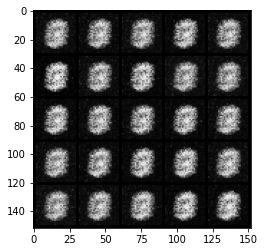

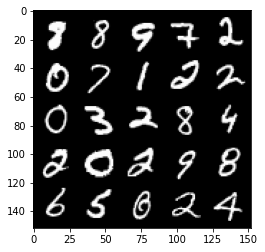

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Gen Loss: 1.8494361865520477, Discr Loss: 0.2597113922238352


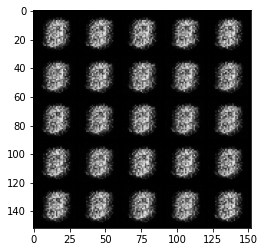

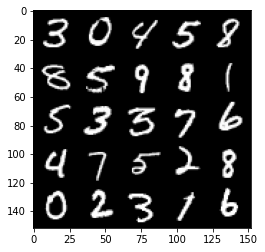

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Gen Loss: 2.192717320442199, Discr Loss: 0.14320726662874228


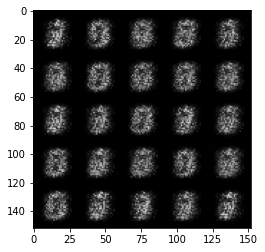

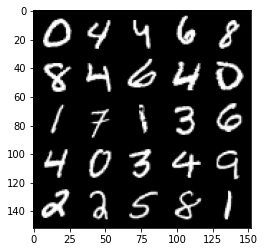

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Gen Loss: 1.8070484957695028, Discr Loss: 0.20956933966279007


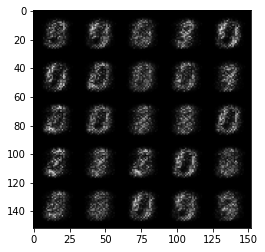

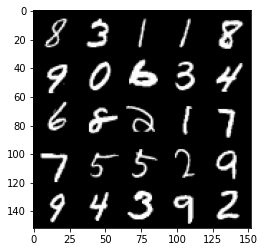

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Gen Loss: 1.7187467384338395, Discr Loss: 0.20189916101098057


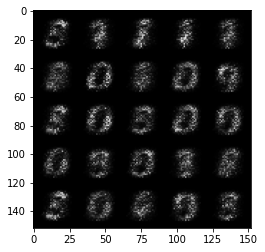

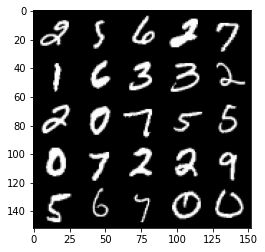

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Gen Loss: 1.956928506851196, Discr Loss: 0.17381592330336584


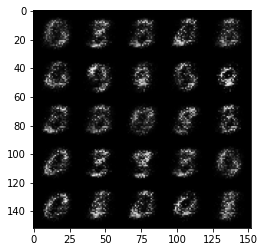

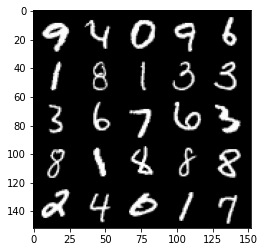

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Gen Loss: 2.294951867818831, Discr Loss: 0.14078345347940904


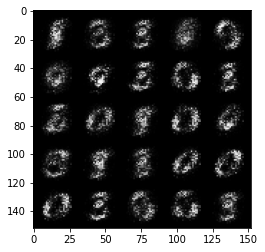

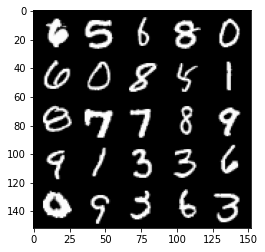

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Gen Loss: 2.785520043849944, Discr Loss: 0.10785674107074732


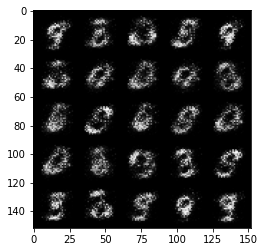

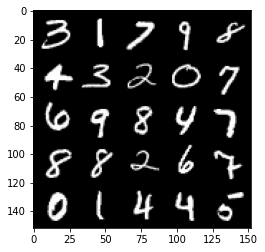

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Gen Loss: 3.044299316406247, Discr Loss: 0.09012562193721528


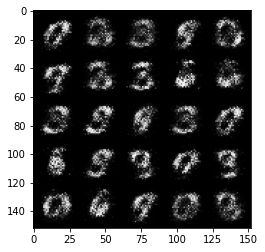

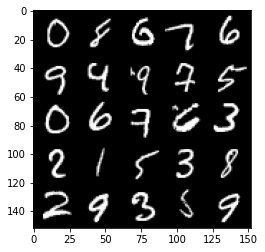

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Gen Loss: 3.4309954752922067, Discr Loss: 0.07872865615040066


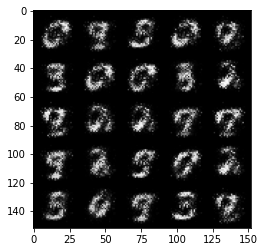

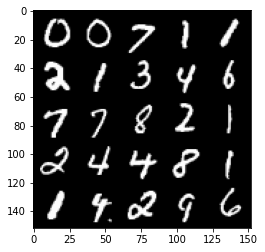

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Gen Loss: 3.4047421674728398, Discr Loss: 0.08252294872701173


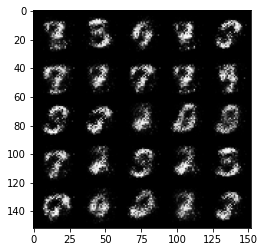

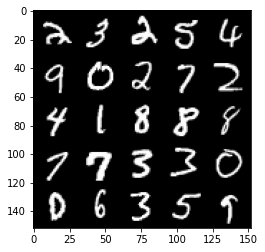

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Gen Loss: 3.753201052665709, Discr Loss: 0.06497085339576002


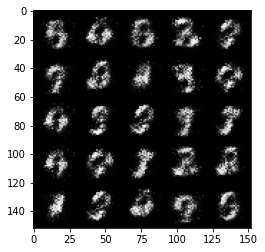

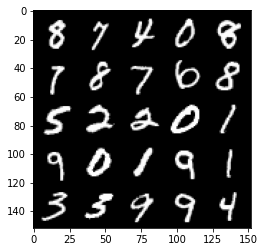

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Gen Loss: 3.9074936366081223, Discr Loss: 0.06980914914607995


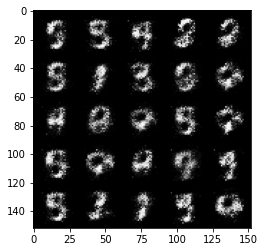

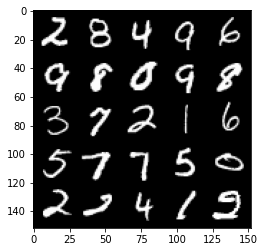

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Gen Loss: 3.784554928302764, Discr Loss: 0.07134284407645465


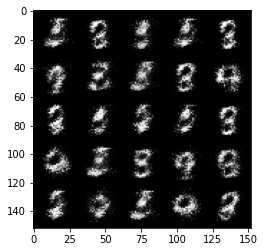

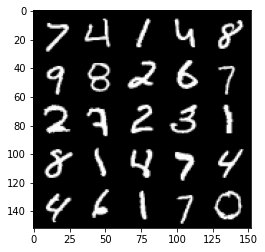

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Gen Loss: 4.133811632156368, Discr Loss: 0.060184093229472664


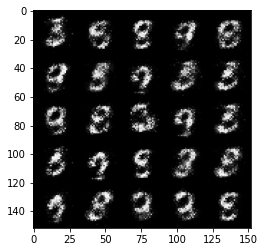

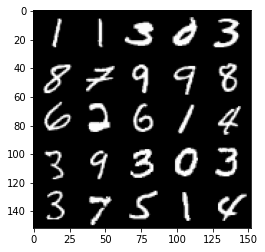

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Gen Loss: 4.094385041713715, Discr Loss: 0.06080484588444232


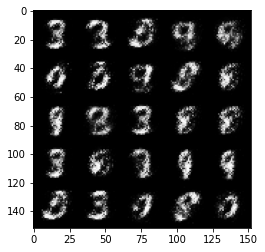

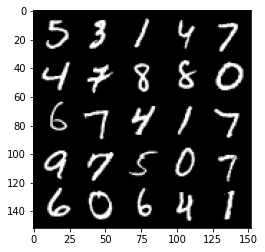

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Gen Loss: 4.112174890995028, Discr Loss: 0.05866338482499119


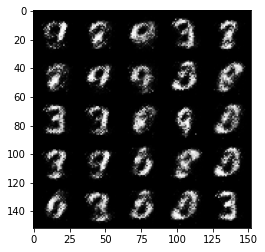

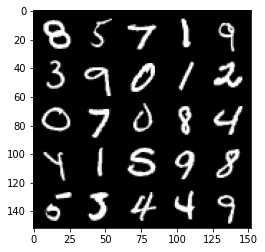

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Gen Loss: 4.206698320388796, Discr Loss: 0.05520867973566055


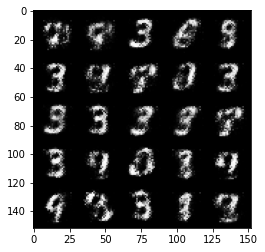

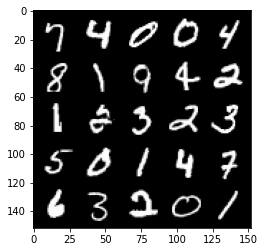

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Gen Loss: 4.117025559425355, Discr Loss: 0.06130349979549648


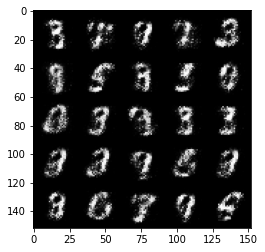

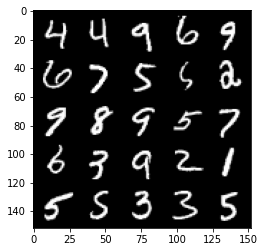

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Gen Loss: 4.20233084535599, Discr Loss: 0.0663907662257552


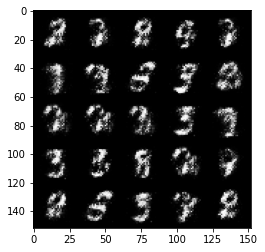

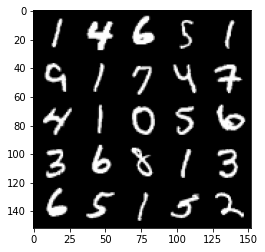

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Gen Loss: 4.135261974334714, Discr Loss: 0.07500242437422272


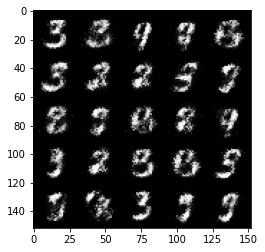

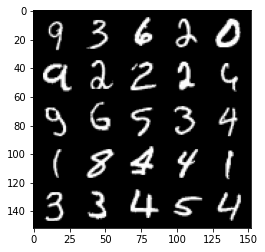

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Gen Loss: 4.12611556148529, Discr Loss: 0.08218656585365537


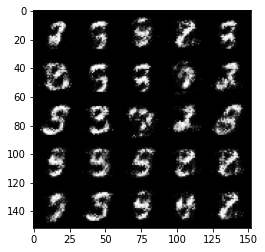

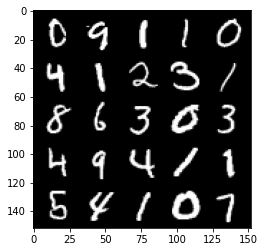

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Gen Loss: 4.051008376598359, Discr Loss: 0.0845415294393898


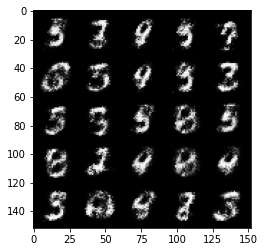

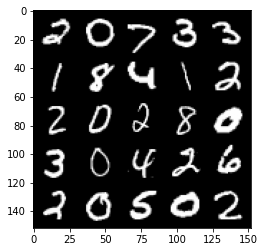

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Gen Loss: 3.866966741085051, Discr Loss: 0.09672336088120942


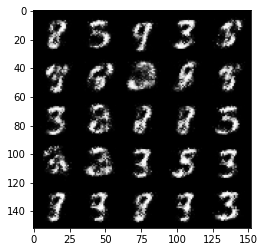

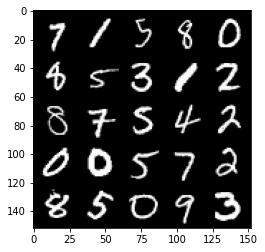

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Gen Loss: 3.9519328413009585, Discr Loss: 0.08713794739544384


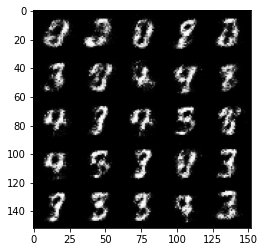

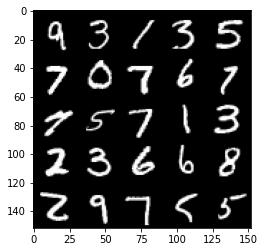

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Gen Loss: 3.7471396546363835, Discr Loss: 0.10170377240329975


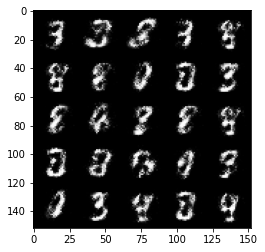

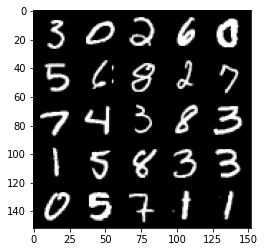

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Gen Loss: 3.6717513990402244, Discr Loss: 0.11041643440723425


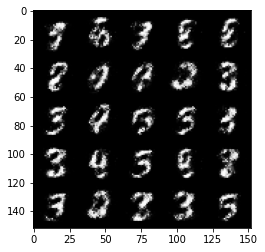

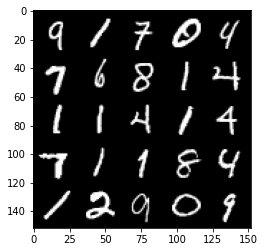

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Gen Loss: 3.6556307234764116, Discr Loss: 0.10388859151303773


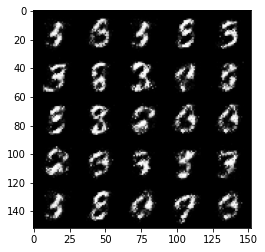

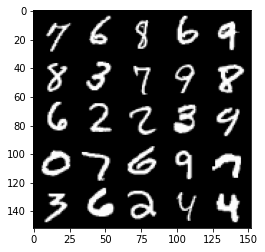

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Gen Loss: 3.7601369524002086, Discr Loss: 0.09155546228587629


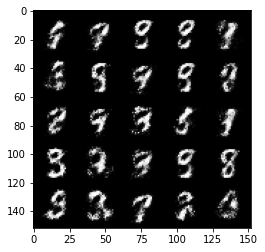

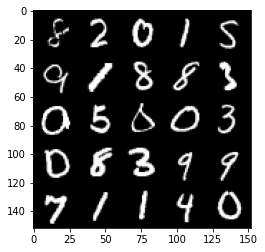

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Gen Loss: 3.7851067605018622, Discr Loss: 0.10705460556596512


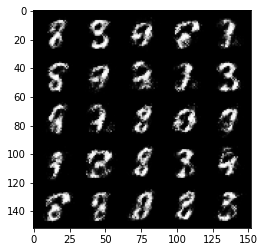

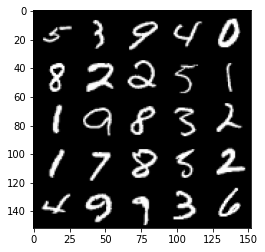

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Gen Loss: 3.7452084698677046, Discr Loss: 0.11893837629258634


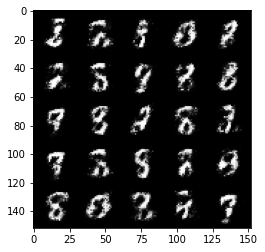

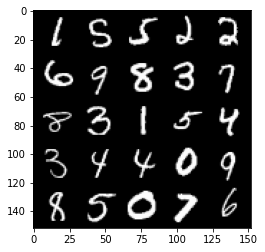

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Gen Loss: 3.576089998722075, Discr Loss: 0.12610651661455638


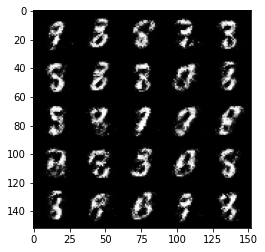

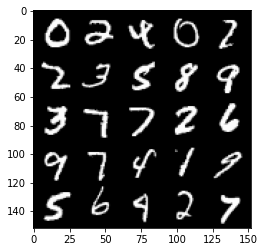

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Gen Loss: 3.5981694374084445, Discr Loss: 0.12372986964136362


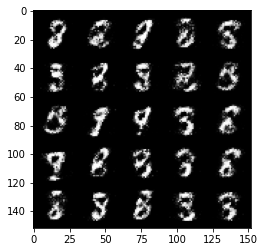

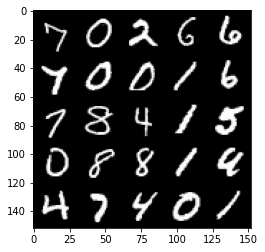

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Gen Loss: 3.611576600551607, Discr Loss: 0.11712266080081458


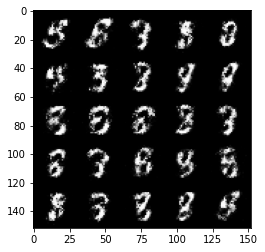

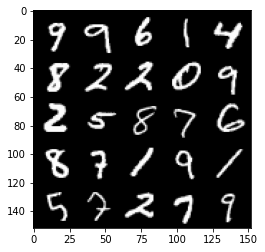

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Gen Loss: 3.4967014474868763, Discr Loss: 0.1383858804255724


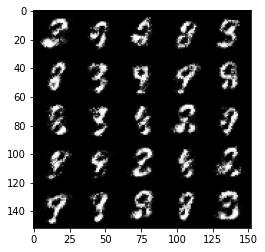

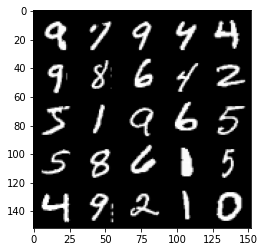

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Gen Loss: 3.5151300063133224, Discr Loss: 0.14722404938936232


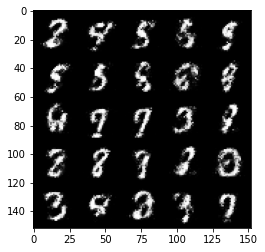

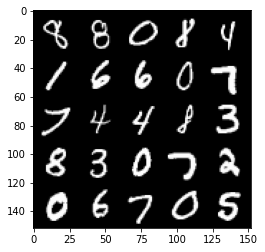

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Gen Loss: 3.3742407531738285, Discr Loss: 0.14889942942559728


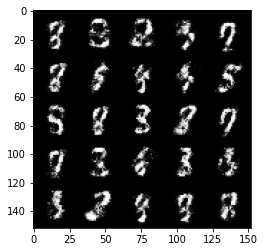

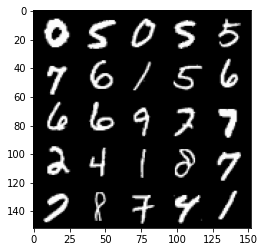

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Gen Loss: 3.1810338463783285, Discr Loss: 0.1583545972853899


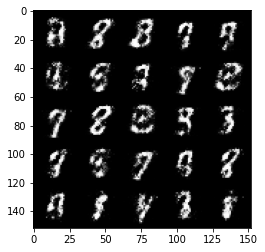

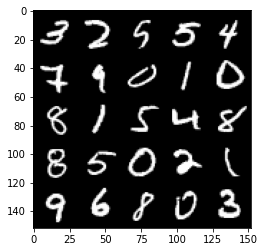

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Gen Loss: 3.2325143432617196, Discr Loss: 0.15284496711194523


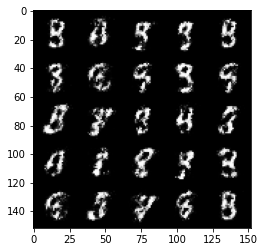

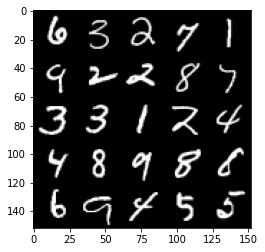

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Gen Loss: 3.322370411396028, Discr Loss: 0.15287311893701538


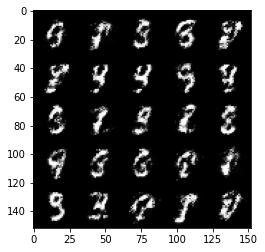

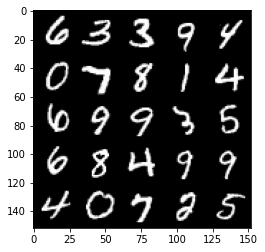

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Gen Loss: 3.1690510163307195, Discr Loss: 0.16447564660012717


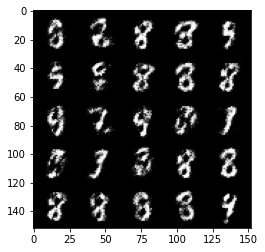

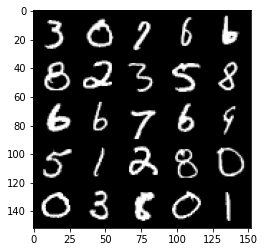

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Gen Loss: 3.067341900348663, Discr Loss: 0.18545763219892988


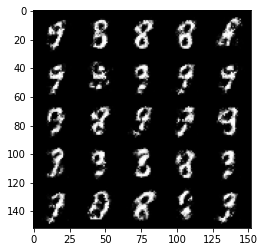

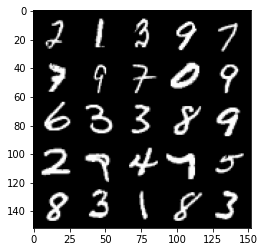

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Gen Loss: 2.9427058463096603, Discr Loss: 0.19230392773449403


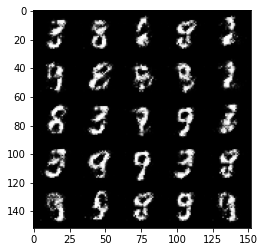

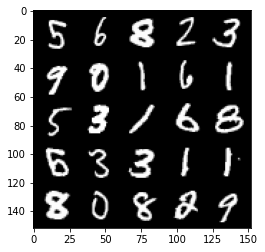

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Gen Loss: 2.9852202243804964, Discr Loss: 0.18222033396363255


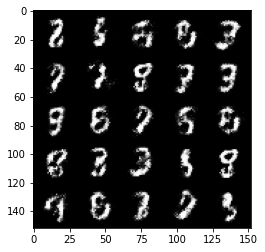

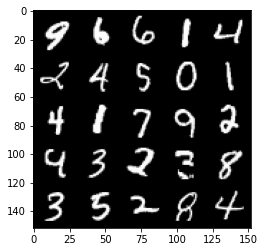

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Gen Loss: 2.9511390318870547, Discr Loss: 0.18955856667459


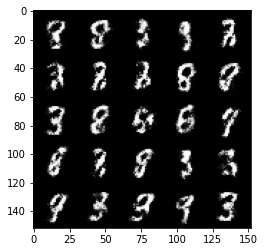

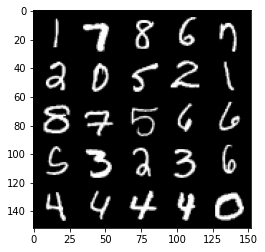

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Gen Loss: 2.827652637481691, Discr Loss: 0.2030981541573999


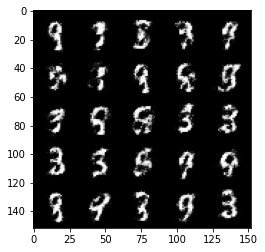

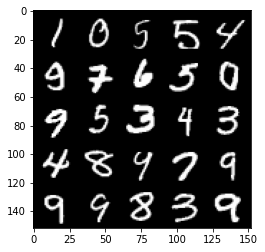

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23500: Gen Loss: 2.712067986488342, Discr Loss: 0.22186583170294752


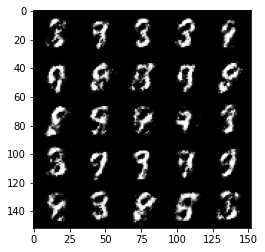

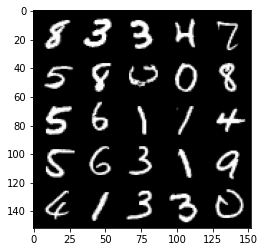

  0%|          | 0/469 [00:00<?, ?it/s]

Step 24000: Gen Loss: 2.7585024542808494, Discr Loss: 0.21121843063831347


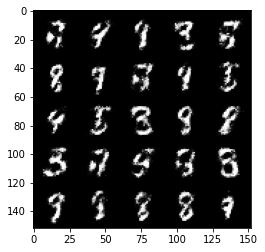

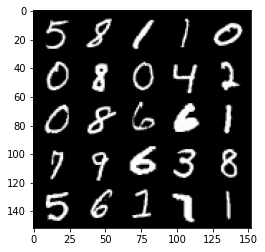

  0%|          | 0/469 [00:00<?, ?it/s]

Step 24500: Gen Loss: 2.8127604165077225, Discr Loss: 0.19756163267791277


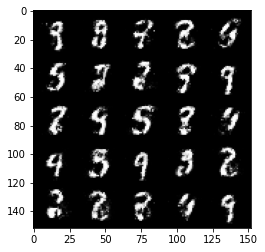

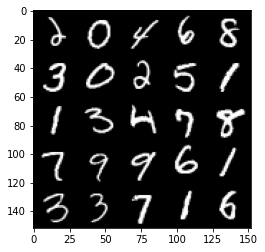

  0%|          | 0/469 [00:00<?, ?it/s]

Step 25000: Gen Loss: 2.88678555870056, Discr Loss: 0.18780812816321846


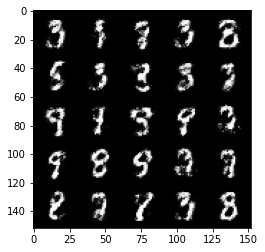

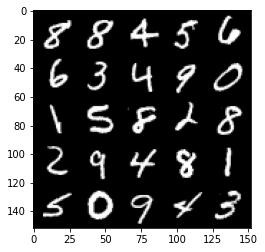

  0%|          | 0/469 [00:00<?, ?it/s]

Step 25500: Gen Loss: 2.8500398216247556, Discr Loss: 0.19747676150500776


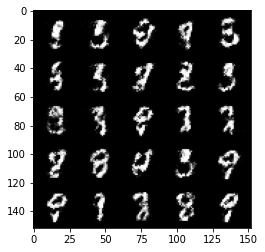

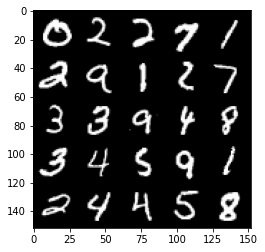

  0%|          | 0/469 [00:00<?, ?it/s]

Step 26000: Gen Loss: 2.7976552662849437, Discr Loss: 0.2217253355085851


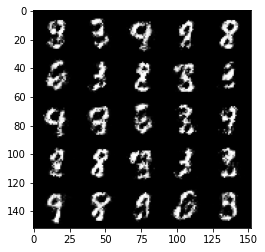

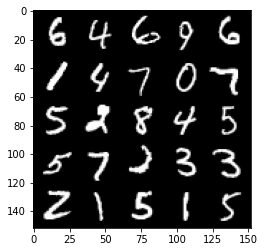

  0%|          | 0/469 [00:00<?, ?it/s]

Step 26500: Gen Loss: 2.6125257439613367, Discr Loss: 0.24962268972396864


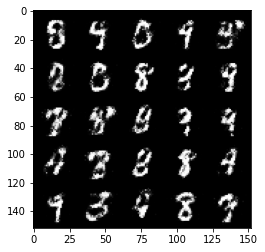

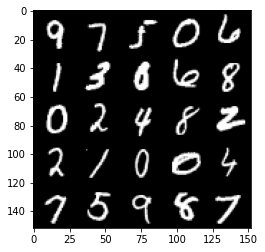

  0%|          | 0/469 [00:00<?, ?it/s]

Step 27000: Gen Loss: 2.6305433778762803, Discr Loss: 0.23670941394567485


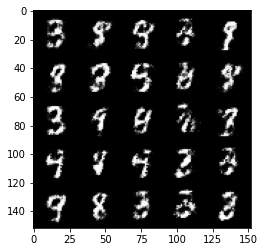

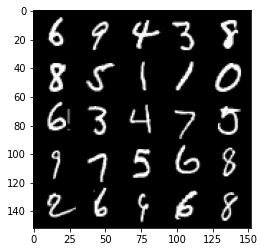

  0%|          | 0/469 [00:00<?, ?it/s]

Step 27500: Gen Loss: 2.6205018794536596, Discr Loss: 0.22787974193692215


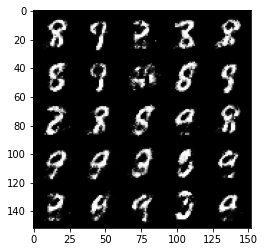

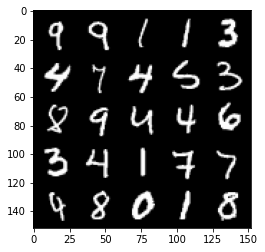

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
step = 0
mean_gen_loss = 0
mean_disc_loss = 0

for epoch in range(n_epochs):
  for image, _ in tqdm(train_loader):
    # image = image[0]
    curr_batch_size = len(image)
    image = image.view(curr_batch_size, -1).to(device)

    discr_optimizer.zero_grad()

    discr_loss = disc_loss(gen, discr, criterion, image, curr_batch_size, noise_dim, device)
    discr_loss.backward(retain_graph=True)
    discr_optimizer.step()

    gen_optimizer.zero_grad()

    generator_loss = gen_loss(gen, discr, criterion, curr_batch_size, noise_dim, device)
    generator_loss.backward()
    gen_optimizer.step()

    mean_disc_loss += discr_loss.item() / display_step
    mean_gen_loss += generator_loss.item() / display_step

    if step % display_step == 0 and step > 0:
      print('Step {}: Gen Loss: {}, Discr Loss: {}'.
            format(step, mean_gen_loss, mean_disc_loss))
      fake_noise = get_noise_vectors(curr_batch_size, noise_dim, device)
      fake = gen(fake_noise)
      show(fake, 25, (image_channels,image_height,image_width), 5)
      show(image, 25, (image_channels,image_height,image_width), 5)
      mean_gen_loss = 0
      mean_disc_loss = 0
    step += 1